In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn import metrics

In [2]:
#import labelled posts 

first_2000 = pd.read_csv('./labelled_posts/train_2000_labelled.csv')
first_2000.head()

,post,manual label,date,source,post_clean
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh


In [5]:
first_2000['manual label'].fillna(0, inplace=True)
first_2000.fillna('nopost', inplace=True)

In [8]:
first_2000.rename(columns = {'manual label': 'label'},inplace=True)
first_2000.head()

,post,label,date,source,post_clean
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh


In [4]:
post_2000_2999 = pd.read_csv('./labelled_posts/2000_2999_labelled_checked.csv')
post_2000_2999.head()

,Unnamed: 0,post,label,date,source,post_clean
0,0,Normal day to day probably but we're talking a...,1.0,2020-04-09 22:12:56,reddit,normal day day probably talking food provided ...
1,1,Maybe they are not the main reason. But it's s...,1.0,2020-05-08 09:27:47,reddit,maybe not main reason still big reason
2,2,Quite f up but there's really nothing much nor...,1.0,2020-06-04 23:53:00,hardwarezone,quite f really nothing much normal citizens li...
3,3,Not everyone. Only Singapore Citizens and PR.\...,1.0,2020-04-05 02:31:02,reddit,not everyone singapore citizens pr cna officia...
4,4,"Maybe too many liao, tmr might be a big spike ...",0.0,2020-05-04 19:34:00,hardwarezone,maybe many tmr might big spike number no point...


In [6]:
post_2000_2999.drop(columns = ['Unnamed: 0'], inplace=True)
post_2000_2999['label'].fillna(0, inplace=True)
post_2000_2999.fillna('nopost', inplace=True)

In [7]:
post_2000_2999.head()

,post,label,date,source,post_clean
0,Normal day to day probably but we're talking a...,1.0,2020-04-09 22:12:56,reddit,normal day day probably talking food provided ...
1,Maybe they are not the main reason. But it's s...,1.0,2020-05-08 09:27:47,reddit,maybe not main reason still big reason
2,Quite f up but there's really nothing much nor...,1.0,2020-06-04 23:53:00,hardwarezone,quite f really nothing much normal citizens li...
3,Not everyone. Only Singapore Citizens and PR.\...,1.0,2020-04-05 02:31:02,reddit,not everyone singapore citizens pr cna officia...
4,"Maybe too many liao, tmr might be a big spike ...",0.0,2020-05-04 19:34:00,hardwarezone,maybe many tmr might big spike number no point...


In [9]:
post_2999 = pd.concat([first_2000, post_2000_2999], ignore_index = True)
print(post_2999.shape)
post_2999.head()

(2998, 5)


,post,label,date,source,post_clean
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh


In [10]:
# function for preprocessing posts in post_2999 
# will not remove stop words to help with sequentiality 

def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
 
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
    
    #return words as a single string 
    return(' '.join(lem))

In [12]:
post_clean_for_rnn = []

for p in post_2999["post"]:
    post_clean_for_rnn.append(preprocess(p))

print(f"checking post_clean_for_rnn: \n{post_clean_for_rnn[1:3]}")

post_2999['post_clean_for_rnn'] = post_clean_for_rnn
post_2999.tail(10)

checking post_clean_for_rnn: 
['for consistency and accuracy it could be easier to use data from the new moh situation report which separate into dorm non dorm foreigner and citizen pr i think they only count those from the named dorm cluster into dorm so those who are either linked to construction site or who live in non cluster dorm get categorized a linked to other cluster or pending investigation respectively so the moh situation report for 28 3 to 10 4 ltp holder ha 545 linked to dorm cluster 126 linked to other cluster and 141 pending investigation whereas my estimate for the same time period is 702 dorm construction related the reason i make these graph is that there are really 2 separate covid problem in singapore circuit breaker can slow down the growth of the case in the general public but other than stopping work at construction site circuit breaker doesn t help the dorm construction site problem the dorm construction site problem ha to be tackled by improving the living con

,post,label,date,source,post_clean,post_clean_for_rnn
2988,Wtf?At least 1.2k dormitories in sg?!?!?!,1.0,2020-04-13 20:54:00,hardwarezone,wtf least 1 2k sg,wtf at least 1 2k dormitory in sg
2989,No wonder ministers wear mask Sent from Xiaomi...,1.0,2020-09-04 20:08:00,hardwarezone,no wonder ministers wear mask sent mi max 3 using,no wonder minister wear mask sent from xiaomi ...
2990,upz for awareness.,1.0,2020-04-27 13:49:00,hardwarezone,upz awareness,upz for awareness
2991,So it becomes more dangerous?Sent from OPPO CP...,1.0,2020-04-26 12:50:00,hardwarezone,becomes dangerous sent oppo cph1877 using,so it becomes more dangerous sent from oppo cp...
2992,I think likely WHO will become the fall guy.Ev...,1.0,2020-04-23 19:27:00,hardwarezone,think likely become fall guy even trump also t...,i think likely who will become the fall guy ev...
2993,"If 40k of them road march to JB CIQ, will they...",1.0,2020-04-13 11:14:00,hardwarezone,40k road march jb ciq deny entry,if 40k of them road march to jb ciq will they ...
2994,Yeah they should just man up and pay the $300 ...,1.0,2020-04-14 19:59:15,reddit,yeah should man pay 300 fine,yeah they should just man up and pay the 300 fine
2995,Probably going to spark an investigation into ...,0.0,2020-04-04 22:01:14,reddit,probably going spark investigation whether com...,probably going to spark an investigation into ...
2996,Like providing living conditions actually fit ...,1.0,2020-04-05 09:52:10,reddit,like providing living conditions actually fit ...,like providing living condition actually fit f...
2997,"not really, need to wait and see what are the ...",1.0,2020-04-29 23:05:00,hardwarezone,not really need wait see figures next week one...,not really need to wait and see what are the f...


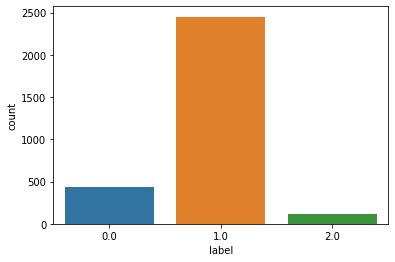

In [13]:
#classes v unbalanced
ax = sns.countplot(post_2999['label'])

In [14]:
#Vectorize post text, by turning each text into either a sequence of integers or into a vector

# The maximum number of words to be used. (most frequent)
max_nb_words = 50000

# Max number of words in each complaint.
max_seq_length = 512

# This is fixed.
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(post_2999['post_clean_for_rnn'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9938 unique tokens.


In [15]:
#truncate and pad 
X = tokenizer.texts_to_sequences(post_2999['post_clean_for_rnn'].values)
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2998, 512)


In [16]:
#one hot encoding labels 
y = pd.get_dummies(post_2999['label']).values
y.shape

(2998, 3)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, 
                                                 stratify = y, random_state = 42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(2398, 512) (2398, 3)
(600, 512) (600, 3)


In [19]:
#SMOTE 

sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

# Scale
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [20]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 512, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 10
batch_size = 32

# class_weight = {0: .8,
#                 1: .5,
#                2: 1}

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data = (X_val, y_val),
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)],
#                     class_weight = class_weight,
                   verbose=1)



Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
75/75 [==============================] - 144s 2s/step - loss: 0.6491 - auc: 0.8771 - val_loss: 0.5760 - val_auc: 0.8854
Epoch 2/10
75/75 [==============================] - 126s 2s/step - loss: 0.5832 - auc: 0.8892 - val_loss: 0.5677 - val_auc: 0.8870
Epoch 3/10
75/75 [==============================] - 112s 1s/step - loss: 0.5815 - auc: 0.8895 - val_loss: 0.5682 - val_auc: 0.8894
Epoch 4/10
75/75 [==============================] - 186s 2s/step - loss: 0.5744 - auc: 0.8939 - val_loss: 0.5655 - val_auc: 0.8966
Epoch 5/10
75/75 [==============================] - 156s 2s/step - loss: 0.5788 - auc: 0.8906 - val_loss: 0.5682 - val_auc: 0.8967
Epoch 6/10
75/75 [==============================] - 140s 2s/step - loss: 0.5798 - auc: 0.8889 - val_loss: 0.5653 - val_auc: 0.8981
Epoch 7/10
75/75 [==============================] - 148s 2s/step - loss: 0.5774 - auc: 0.8888 - val_loss: 0.5642 - val_auc: 0.9005
Ep

19/19 [==============================] - 2s 116ms/step - loss: 0.5643 - auc: 0.8978
Test set
  Loss: 0.564
  Accuracy: 0.898


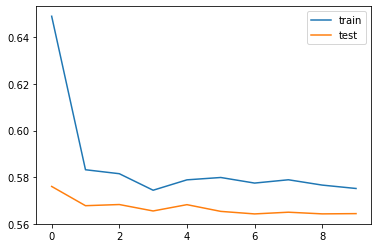

In [23]:
acc = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [24]:
#fit X and y to model to predict other unlabelled posts 

model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1)

Epoch 1/10
94/94 [==============================] - 150s 2s/step - loss: 0.5726 - auc: 0.8961
Epoch 2/10
94/94 [==============================] - 150s 2s/step - loss: 0.4314 - auc: 0.9503
Epoch 3/10
94/94 [==============================] - 174s 2s/step - loss: 0.2759 - auc: 0.9795
Epoch 4/10
94/94 [==============================] - 191s 2s/step - loss: 0.1876 - auc: 0.9900
Epoch 5/10
94/94 [==============================] - 209s 2s/step - loss: 0.1455 - auc: 0.9943
Epoch 6/10
94/94 [==============================] - 194s 2s/step - loss: 0.1102 - auc: 0.9966
Epoch 7/10
94/94 [==============================] - 185s 2s/step - loss: 0.0743 - auc: 0.9986
Epoch 8/10
94/94 [==============================] - 143s 2s/step - loss: 0.0551 - auc: 0.9992
Epoch 9/10
94/94 [==============================] - 145s 2s/step - loss: 0.0418 - auc: 0.9996
Epoch 10/10
94/94 [==============================] - 153s 2s/step - loss: 0.0284 - auc: 0.9998


In [25]:
#import unlabelled data to pred sentiment 

unlabelled = pd.read_csv('./unlabelled_posts/3000_3999_unlabelled.csv')
unlabelled.head()

,post,manual label,date,source,post_clean
0,lets shoot to the moon.,NaN,2020-04-14 20:22:00,hardwarezone,lets shoot moon
1,The dorm operators are there for profit. They ...,NaN,2020-04-06 21:58:35,reddit,operators profit stick many men room law allow...
2,"Is not talent as an excuse, loyalty is the utm...",NaN,2020-06-06 14:14:00,sgtalk,not talent excuse loyalty utmost important no ...
3,smlj also set up task forcelike that means no ...,NaN,2020-09-04 20:36:00,hardwarezone,smlj also set task forcelike means no individu...
4,We're now at the endgame guys.,NaN,2020-04-10 01:45:46,reddit,endgame guys


In [31]:
unlabelled.isnull().sum()
unlabelled['post'].fillna('nopost', inplace=True)

In [32]:
unlabelled_posts = unlabelled['post']

In [33]:
#predict sentiment class of post in unlabelled set (3000-3999)
posts_to_pred = []

for post in unlabelled_posts:
    seq = tokenizer.texts_to_sequences(post)
    padded = pad_sequences(seq, maxlen=max_seq_length)
    posts_to_pred.append(padded)
    

In [34]:
print(len(posts_to_pred))
posts_to_pred[1]

1000


array([[  0,   0,   0, ...,   0,   0,  25],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0, 650],
       ...,
       [  0,   0,   0, ...,   0,   0, 555],
       [  0,   0,   0, ...,   0,   0, 650],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [35]:
preds = []

for i in range(len(posts_to_pred)):
    pred = model.predict_classes(posts_to_pred[i], verbose = 1)
    preds.append(pred.sum()/len(pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
9/9 [==============================] - 2s 201ms/step


20/20 [==============================] - 4s 176ms/step


2/2 [==============================] - 0s 77ms/step


2/2 [==============================] - 0s 55ms/step


In [36]:
print(len(preds))
preds[1]

1000


1.0

In [37]:
unlabelled['labels'] = preds 
unlabelled.tail()

,post,manual label,date,source,post_clean,labels
995,"If the transmission is within the dormitories,...",NaN,2020-05-04 20:02:00,hardwarezone,transmission within still asked quarantine ins...,1.0
996,Can apply for exemption to get your workers ou...,NaN,2020-05-02 08:01:40,reddit,apply exemption get essential work,1.0
997,SG is in crisis now and soon you will see many...,NaN,2020-09-04 22:46:00,hardwarezone,sg crisis soon see many walking zombies spreading,1.0
998,"Total Swabs Tested224,262 - 175,604 = 48,658To...",NaN,2020-05-14 15:54:00,hardwarezone,total swabs tested224 262 175 604 48 658total ...,1.0
999,Satki covidsSent from my Toilet Bowl using GAGT,NaN,2020-04-23 16:20:00,hardwarezone,satki covidssent toilet bowl using,1.0


In [38]:
unlabelled.to_csv('./labelled_posts/3000_3999_labelled.csv')